# DA Throttling Analysis on Base

**Context**
- Investigate two windows for DA throttling: May 27, 4:14 pm → May 29, 3:29 pm CDT (highlight May 28 ~9:05–9:35 am CDT) and July 31, 5:30–6:30 pm PT.
- Sampling: 10% random, seeded for the long CDT window; full fetch for the 1-hour PT window.

**Analysis**
- Analyze DA throttling events using time-series visualization to understand:
  - When throttling starts/ends
  - How DA utilization patterns change during throttling
  - Base fee patterns


# Step 1: Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
# Core imports
import sys
from pathlib import Path
import polars as pl
from datetime import datetime, timedelta, timezone
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time
import pandas as pd
import matplotlib.dates as mdates
from zoneinfo import ZoneInfo 

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Import Jovian modules
from jovian_src.chain_config import (
    get_chain_display_name
)
from jovian_src.constants import (
    DEFAULT_DA_FOOTPRINT_GAS_SCALARS
)
from jovian_src.clickhouse_fetcher import (
    load_gas_limits,
    fetch_top_percentile_blocks,
    fetch_random_sample_blocks,
    get_gas_limit_for_date
)
from jovian_src.analysis_functions import (
    perform_jovian_analysis,
    generate_jovian_recommendation
)
from jovian_src.visualization_jovian import (
    generate_all_visualizations,
    plot_block_metric_distribution
)

print("✅ Modules loaded successfully")
print(f"✅ Available scalars: {DEFAULT_DA_FOOTPRINT_GAS_SCALARS}")

✅ Modules loaded successfully
✅ Available scalars: [160, 400, 600, 800]


# Step 2: Configuration

In [3]:
# ============================================================================
# ANALYSIS CONFIGURATION - EDIT THESE PARAMETERS
# ============================================================================

# Chain selection
CHAIN = "base"  # Options: base, op

# Sampling method
SAMPLING_METHOD = "random"  # "top_percentile" or "random"
RANDOM_SEED = 42     # For reproducible random sampling
SAMPLE_FRACTION = 0.1  # For random sampling (1% = 0.01)

from datetime import datetime
# START_DATETIME = datetime(2025, 8, 1, 0, 30, 0)  # utc
# END_DATETIME = datetime(2025, 8, 1, 1, 30, 0)    # utc
START_DATETIME = datetime(2025, 5, 27, 21, 14, 0)  # utc
END_DATETIME = datetime(2025, 5, 29, 20, 29, 0)    # utc
START_DATE = START_DATETIME.strftime("%Y-%m-%d")
END_DATE = END_DATETIME.strftime("%Y-%m-%d")

# Analysis parameters
DA_FOOTPRINT_GAS_SCALARS = DEFAULT_DA_FOOTPRINT_GAS_SCALARS  # [160, 400, 600, 800]
BLOCK_LIMIT = None   # None = all blocks for selected method
FORCE_REFRESH = False  # Set True to ignore cache and re-download

# Output settings
SAVE_RESULTS = True
SHOW_PLOTS = True

print("✅ Configuration loaded:")
print(f"   Chain: {CHAIN}")
print(f"   Method: {SAMPLING_METHOD}")
if SAMPLING_METHOD == "top_percentile":
    print(f"   Percentile: Top {100-PERCENTILE}%")
else:
    print(f"   Sample: {int(SAMPLE_FRACTION*100)}% random")
print(f"   Date range: {START_DATE} to {END_DATE}")

✅ Configuration loaded:
   Chain: base
   Method: random
   Sample: 10% random
   Date range: 2025-05-27 to 2025-05-29


# Step 3: Initialize Analysis Environment

In [4]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================

# Paths
DATA_PATH = Path("../gas_limits")
FILE_PATH = f"{CHAIN}_gas_limits.csv"
CACHE_DIR = Path(".cache")
OUTPUT_DIR = Path(f"../results/{CHAIN}/jovian_analysis_{SAMPLING_METHOD}_{START_DATE}_{END_DATE}")

# Create output directory
if SAVE_RESULTS:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"📁 Output directory: {OUTPUT_DIR}")

# Generate date list
start = datetime.strptime(START_DATE, "%Y-%m-%d")
end = datetime.strptime(END_DATE, "%Y-%m-%d")
DATES_TO_ANALYZE = [(start + timedelta(days=i)).strftime("%Y-%m-%d") 
                     for i in range((end - start).days + 1)]

# Load gas limits
date_gas_limits = {}
print(f"📊 Loading gas limits for {CHAIN}...")
gas_limits_df = load_gas_limits(csv_path=f"{DATA_PATH}/{FILE_PATH}")


# Get gas limits for all dates

for date in DATES_TO_ANALYZE:
    gas_limit = get_gas_limit_for_date(date, gas_limits_df, chain=CHAIN)
    date_gas_limits[date] = gas_limit
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"📊 Gas limit for {date}: {gas_limit:,}")

print(f"✅ Loaded gas limits for {len(date_gas_limits)} dates")

# Determine gas limit for combined analysis
unique_limits = set(date_gas_limits.values())
if len(unique_limits) > 1:
    print(f"\n⚠️  Multiple gas limits detected: {', '.join(f'{gl:,}' for gl in sorted(unique_limits))}")
    # Use the most common gas limit for combined analysis
    limit_counts = Counter(date_gas_limits.values())
    ANALYSIS_GAS_LIMIT = limit_counts.most_common(1)[0][0]
    print(f"📊 Using most common for combined analysis: {ANALYSIS_GAS_LIMIT:,}")
else:
    ANALYSIS_GAS_LIMIT = list(unique_limits)[0]
    print(f"\n📊 Consistent gas limit across all dates: {ANALYSIS_GAS_LIMIT:,}")


# Cache configuration
def _method_key():
    """Generate cache key based on sampling method and parameters."""
    if SAMPLING_METHOD == "top_percentile":
        return f"top{PERCENTILE*100:.1f}pct_lim{BLOCK_LIMIT}"
    return f"rand_frac{SAMPLE_FRACTION}_seed{RANDOM_SEED}"

def _cache_path(date_str: str) -> Path:
    """Generate cache file path for a specific date."""
    return CACHE_DIR / CHAIN / _method_key() / f"{date_str}.parquet"

print(f"🔧 Cache method: {_method_key()}")
print(f"📅 Dates to analyze: {len(DATES_TO_ANALYZE)}")

📁 Output directory: ../results/base/jovian_analysis_random_2025-05-27_2025-05-29
📊 Loading gas limits for base...
📊 Gas limit for 2025-05-27: 140,000,000
📊 Gas limit for 2025-05-28: 140,000,000
📊 Gas limit for 2025-05-29: 140,000,000
✅ Loaded gas limits for 3 dates

📊 Consistent gas limit across all dates: 140,000,000
🔧 Cache method: rand_frac0.1_seed42
📅 Dates to analyze: 3


# Step 4: Load Data and Caching

In [5]:
# ============================================================================
# DATA FETCHING WITH CACHING
# ============================================================================

print(f"📥 Fetching data for {CHAIN} using {SAMPLING_METHOD} method...")
print("=" * 60)

all_dataframes = []
fetch_summary = []
per_date_dataframes = {}

# Display method description
method_display = f"top {100-PERCENTILE}%" if SAMPLING_METHOD == "top_percentile" else f"{int(SAMPLE_FRACTION*100)}% random"
print(f"📊 Method: {method_display} blocks")

start_time = time.time()

for date in DATES_TO_ANALYZE:

    # Get gas limit for this date from the dictionary
    gas_limit = date_gas_limits[date]
    cache_file = _cache_path(date)


    # Show progress for shorter date ranges
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"\n📅 {date} (gas limit: {gas_limit:,})")
    
    # Check cache first
    if cache_file.exists() and not FORCE_REFRESH:
        df = pl.read_parquet(cache_file)
        actual_gas_limit = gas_limit
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   📦 Cache hit → {len(df):,} transactions")
    else:
        # Fetch from source
        cache_file.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            if SAMPLING_METHOD == "top_percentile":
                df, actual_gas_limit = fetch_top_percentile_blocks(
                    chain=CHAIN,
                    date=date,
                    percentile=PERCENTILE,
                    limit=BLOCK_LIMIT,
                    gas_limit=gas_limit
                )
            else:
                df, actual_gas_limit = fetch_random_sample_blocks(
                    chain=CHAIN,
                    date=date,
                    sample_fraction=SAMPLE_FRACTION,
                    gas_limit=gas_limit,
                    seed=RANDOM_SEED,
                    start_datetime=START_DATETIME,
                    end_datetime=END_DATETIME
                )
            
            # Save to cache if we got data
            if not df.is_empty():
                df.write_parquet(cache_file)
                if len(DATES_TO_ANALYZE) <= 7:
                    print(f"   💾 Saved to cache → {len(df):,} transactions")
            
        except Exception as e:
            print(f"   ❌ Error fetching {date}: {e}")
            df = pl.DataFrame()
            actual_gas_limit = gas_limit
    
    # Process results
    if not df.is_empty():
        all_dataframes.append(df)
        per_date_dataframes[date] = df
        blocks = df['block_number'].n_unique()
        txs = len(df)
        fetch_summary.append({
            'date': date,
            'blocks': blocks,
            'transactions': txs,
            'gas_limit': actual_gas_limit,
            'df': df
        })
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ✅ {blocks} blocks, {txs:,} transactions")
    else:
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ⚠️  No data for {date}")

total_time = time.time() - start_time
print(f"\n📊 Fetching complete!")
print(f"   Total time: {total_time:.1f}s")
print(f"   Average per date: {total_time/len(DATES_TO_ANALYZE):.1f}s")

# Combine all data
if all_dataframes:
    combined_df = pl.concat(all_dataframes)
    print(f"\n✅ Data summary:")
    print(f"   Total dates with data: {len(fetch_summary)}")
    print(f"   Total blocks: {combined_df['block_number'].n_unique():,}")
    print(f"   Total transactions: {len(combined_df):,}")
else:
    print("\n❌ No data retrieved. Please check your parameters.")
    combined_df = pl.DataFrame()

# Determine gas limit for combined analysis
unique_limits = set(date_gas_limits.values())
if len(unique_limits) > 1:
    print(f"\n⚠️  Multiple gas limits detected: {', '.join(f'{gl:,}' for gl in sorted(unique_limits))}")
    # Use the most common gas limit for combined analysis
    limit_counts = Counter(date_gas_limits.values())
    ANALYSIS_GAS_LIMIT = limit_counts.most_common(1)[0][0]
    print(f"📊 Using most common for combined analysis: {ANALYSIS_GAS_LIMIT:,}")
else:
    ANALYSIS_GAS_LIMIT = list(unique_limits)[0]
    print(f"\n📊 Consistent gas limit across all dates: {ANALYSIS_GAS_LIMIT:,}")

📥 Fetching data for base using random method...
📊 Method: 10% random blocks

📅 2025-05-27 (gas limit: 140,000,000)
   📦 Cache hit → 107,575 transactions
   ✅ 498 blocks, 107,575 transactions

📅 2025-05-28 (gas limit: 140,000,000)
   📦 Cache hit → 1,198,477 transactions
   ✅ 4320 blocks, 1,198,477 transactions

📅 2025-05-29 (gas limit: 140,000,000)
   📦 Cache hit → 1,198,995 transactions
   ✅ 3687 blocks, 1,198,995 transactions

📊 Fetching complete!
   Total time: 1.5s
   Average per date: 0.5s

✅ Data summary:
   Total dates with data: 3
   Total blocks: 8,505
   Total transactions: 2,505,047

📊 Consistent gas limit across all dates: 140,000,000


In [6]:
# inspect combined_df
print(combined_df.columns)
combined_df.head()

['block_number', 'transaction_index', 'input', 'calldata_size', 'block_total_calldata', 'block_total_gas_used', 'block_timestamp', 'base_fee_per_gas', 'gas_limit', 'chain', 'sampling_method']


block_number,transaction_index,input,calldata_size,block_total_calldata,block_total_gas_used,block_timestamp,base_fee_per_gas,gas_limit,chain,sampling_method
i64,i64,str,f64,f64,i64,u32,i64,i32,str,str
30795547,0,"""0x098999be000008dd00101c120000…",176.0,109655.0,68576433,1748380441,603275,140000000,"""base""","""random"""
30795547,1,"""0x3a57129900000000000000000000…",388.0,109655.0,68576433,1748380441,603275,140000000,"""base""","""random"""
30795547,2,"""0x""",0.0,109655.0,68576433,1748380441,603275,140000000,"""base""","""random"""
30795547,3,"""0xfd66ae06419f2b070e6d67ce731e…",115.0,109655.0,68576433,1748380441,603275,140000000,"""base""","""random"""
30795547,4,"""0x1505d3bb00000000000000000000…",196.0,109655.0,68576433,1748380441,603275,140000000,"""base""","""random"""


# Step 5: Perform Jovian Analysis

In [7]:
# Analyze combined data with multiple calldata footprint gas scalars
if not combined_df.is_empty():
    print(f"📊 ANALYZING COMBINED DATA")
    print("=" * 60)
    print(f"Chain: {get_chain_display_name(CHAIN)}")
    print(f"Dates analyzed: {len(fetch_summary)}")
    print(f"Gas limit: {ANALYSIS_GAS_LIMIT:,}")
    print(f"Sampling method: {SAMPLING_METHOD}")
    
    analysis_results = perform_jovian_analysis(
        df=combined_df,
        gas_limit=ANALYSIS_GAS_LIMIT,
        da_footprint_gas_scalars=DEFAULT_DA_FOOTPRINT_GAS_SCALARS,
        chain=CHAIN,
        sampling_method=SAMPLING_METHOD,
        start_date=START_DATE,
        end_date=END_DATE,
        show_progress=True
    )
    
    print("\n✅ Jovian analysis complete!")
else:
    print("❌ No data to analyze")
    analysis_results = {}

📊 ANALYZING COMBINED DATA
Chain: Base
Dates analyzed: 3
Gas limit: 140,000,000
Sampling method: random

🚀 JOVIAN ANALYSIS SUMMARY
Chain: Base
Sampling Method: random
Date Range: 2025-05-27 → 2025-05-29
Gas Limit: 140,000,000
DA Footprint Gas Scalars: [160, 400, 600, 800]

📊 Analyzing Base with DA footprint gas scalar: 160
   Effective limit: 875,000 bytes
   Sampling method: random
🚀 Analyzing 8505 blocks with 10 workers...


Processing blocks: 100%|██████████| 8505/8505 [00:33<00:00, 257.17it/s]


   ✅ Blocks exceeding: 0/8283 (0.0%)
   📈 Avg utilization: 3.02%
   🗜️ Avg compression ratio: 2.05x

📊 Analyzing Base with DA footprint gas scalar: 400
   Effective limit: 350,000 bytes
   Sampling method: random
🚀 Analyzing 8505 blocks with 10 workers...


Processing blocks: 100%|██████████| 8505/8505 [00:34<00:00, 247.58it/s]


   ✅ Blocks exceeding: 0/8283 (0.0%)
   📈 Avg utilization: 7.54%
   🗜️ Avg compression ratio: 2.05x

📊 Analyzing Base with DA footprint gas scalar: 600
   Effective limit: 233,333 bytes
   Sampling method: random
🚀 Analyzing 8505 blocks with 10 workers...


Processing blocks: 100%|██████████| 8505/8505 [00:37<00:00, 224.50it/s]


   ✅ Blocks exceeding: 0/8283 (0.0%)
   📈 Avg utilization: 11.31%
   🗜️ Avg compression ratio: 2.05x

📊 Analyzing Base with DA footprint gas scalar: 800
   Effective limit: 175,000 bytes
   Sampling method: random
🚀 Analyzing 8505 blocks with 10 workers...


Processing blocks: 100%|██████████| 8505/8505 [00:32<00:00, 263.88it/s]


   ✅ Blocks exceeding: 0/8283 (0.0%)
   📈 Avg utilization: 15.08%
   🗜️ Avg compression ratio: 2.05x

✅ Jovian analysis complete!


In [8]:
# Display analysis results including compression metrics
if analysis_results:
    print(f"🚀 JOVIAN ANALYSIS RESULTS - {get_chain_display_name(CHAIN)}")
    print("=" * 60)
    
    for scalar in sorted(analysis_results.keys()):
        result = analysis_results[scalar]
        print(f"\n🔹 Calldata Footprint Gas Scalar: {scalar}")
        print(f"   Effective limit: {result.gas_limit // scalar:,} bytes")
        print(f"   Blocks exceeding: {result.blocks_exceeding}/{result.total_blocks} ({result.percentage_exceeding:.2f}%)")
        print(f"   Avg utilization: {result.avg_utilization:.2%}")
        print(f"   Max utilization: {result.max_utilization:.2%}")

        # ⛽ DA footprint vs *block gas used* (as % of gas used)
        if getattr(result, "blocks_with_gas_used", 0) > 0:
            mean_pct   = result.avg_util_vs_gas_used * 100
            median_pct = result.median_util_vs_gas_used * 100
            p95_pct    = result.p95_util_vs_gas_used * 100

            over_cnt_measured = int(round(result.share_over_1_vs_used * result.blocks_with_gas_used))
            over_pct_measured = result.share_over_1_vs_used * 100

            # Optional: express as share of ALL blocks too (matches the “Blocks exceeding” style)
            over_pct_all = (over_cnt_measured / result.total_blocks * 100) if result.total_blocks else 0

            print(f"\n   ⛽ DA footprint vs Block Gas Used:")
            print(f"      mean:   {mean_pct:.1f}%")
            print(f"      median: {median_pct:.1f}%   |   p95: {p95_pct:.1f}%")
            print(f"      Blocks over gas-used budget (>100%): "
                f"{over_cnt_measured}/{result.blocks_with_gas_used} ({over_pct_measured:.1f}%) ")
        else:
            print("\n   ⛽ DA footprint vs Block Gas Used: n/a (no blocks had block_gas_used)")
        
        # Show compression metrics
        if result.compression_metrics:
            print(f"\n   📊 Compression Metrics:")
            print(f"      Avg compression ratio: {result.compression_metrics.get('avg_compression_ratio', 0):.2f}x")
            print(f"      Median compression: {result.compression_metrics.get('median_compression_ratio', 0):.2f}x")
            print(f"      DA efficiency: {result.compression_metrics.get('avg_da_efficiency', 0):.1%}")
        
        if result.blocks_exceeding > 0:
            print(f"   Avg excess: {result.avg_excess_percentage:.1f}%")
            print(f"   Max excess: {result.max_excess_percentage:.1f}%")




🚀 JOVIAN ANALYSIS RESULTS - Base

🔹 Calldata Footprint Gas Scalar: 160
   Effective limit: 875,000 bytes
   Blocks exceeding: 0/8283 (0.00%)
   Avg utilization: 3.02%
   Max utilization: 11.39%

   ⛽ DA footprint vs Block Gas Used:
      mean:   6.4%
      median: 5.9%   |   p95: 10.6%
      Blocks over gas-used budget (>100%): 0/8283 (0.0%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.05x
      Median compression: 2.00x
      DA efficiency: 25.9%

🔹 Calldata Footprint Gas Scalar: 400
   Effective limit: 350,000 bytes
   Blocks exceeding: 0/8283 (0.00%)
   Avg utilization: 7.54%
   Max utilization: 28.49%

   ⛽ DA footprint vs Block Gas Used:
      mean:   15.9%
      median: 14.7%   |   p95: 26.5%
      Blocks over gas-used budget (>100%): 0/8283 (0.0%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.05x
      Median compression: 2.00x
      DA efficiency: 25.9%

🔹 Calldata Footprint Gas Scalar: 600
   Effective limit: 233,333 bytes
   Blocks exceeding: 0/8283

# Step 6: Generate Jovian Recommendation & Visualizations

In [9]:
print(f"\n🎯 RECOMMENDATION - {get_chain_display_name(CHAIN)}")
print("=" * 60)

rec = generate_jovian_recommendation(
    results=analysis_results,            
    chain=CHAIN,
    start_date=START_DATE,
    end_date=END_DATE,
    target_excess_rate=0.01
)

for opt in rec["all_options"]:
    s = opt["da_footprint_gas_scalar"]
    tick = "✅" if opt["blocks_exceeding_pct"] <= 1 else ("⚠️" if opt["blocks_exceeding_pct"] <= 5 else "❌")

    # Avg compression from recommendation dict
    avg_comp = opt.get("avg_compression_ratio", 0.0)

    # Median compression from analysis_results (no lib changes needed)
    median_comp = 0.0
    if s in analysis_results and analysis_results[s].compression_metrics:
        median_comp = analysis_results[s].compression_metrics.get("median_compression_ratio", 0.0)

    # DA footprint > gas used share (only if measured)
    measured = opt.get("measured_blocks_gas_used", 0) or 0
    over_pct = opt.get("over_gas_used_pct", None)
    over_str = (
        f" | DA footprint > block gas used: {over_pct:.2f}% of {measured:,} blocks"
        if (over_pct is not None and measured > 0) else ""
    )

    print(
        f"{tick} Scalar {s}: {opt['blocks_exceeding_pct']:.2f}% exceeds gas limit, {opt['assessment']} | "
        f"avg comp {avg_comp:.2f}x (median {median_comp:.2f}x){over_str}"
    )



🎯 RECOMMENDATION - Base
✅ Scalar 160: 0.00% exceeds gas limit, Very Conservative | avg comp 2.05x (median 2.00x) | DA footprint > block gas used: 0.00% of 8,283 blocks
✅ Scalar 400: 0.00% exceeds gas limit, Very Conservative | avg comp 2.05x (median 2.00x) | DA footprint > block gas used: 0.00% of 8,283 blocks
✅ Scalar 600: 0.00% exceeds gas limit, Very Conservative | avg comp 2.05x (median 2.00x) | DA footprint > block gas used: 0.43% of 8,283 blocks
✅ Scalar 800: 0.00% exceeds gas limit, Very Conservative | avg comp 2.05x (median 2.00x) | DA footprint > block gas used: 1.56% of 8,283 blocks


📊 Generating enhanced visualizations for Base...
📊 Generating enhanced size estimates histogram...
✅ Saved size estimates histogram to ../results/base/jovian_analysis_random_2025-05-27_2025-05-29/1_da_usage_estimates_histogram.png
📊 Generating compression ratio histogram...
✅ Saved enhanced compression histogram to ../results/base/jovian_analysis_random_2025-05-27_2025-05-29/2_compression_histogram.png
📊 Generating exceeding limits analysis...
✅ Saved exceeding limits analysis to ../results/base/jovian_analysis_random_2025-05-27_2025-05-29/3_exceeding_limits_analysis.png
📊 Generating excess distribution...
✅ No blocks exceed limits for any scalar
📊 Generating over-utilization analysis...
✅ Saved over-utilization analysis to ../results/base/jovian_analysis_random_2025-05-27_2025-05-29/5_over_utilization_analysis.png
📊 Generating scalar comparison...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:747: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved scalar comparison to ../results/base/jovian_analysis_random_2025-05-27_2025-05-29/6_scalar_comparison.png
📊 Generating comprehensive summary...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:1098: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:1102: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved comprehensive summary to ../results/base/jovian_analysis_random_2025-05-27_2025-05-29/7_comprehensive_summary.png
✅ Generated 7 visualizations

✅ Generated 7 visualizations:
   1. Size estimates histogram (with vertical lines & zones)
   2. Compression ratio histogram (with percentiles & zones)
   3. Blocks exceeding limits analysis
   4. Excess distribution
   5. Over-utilization percentages
   6. Scalar comparison
   7. Comprehensive summary (NEW)

📁 Saved to: ../results/base/jovian_analysis_random_2025-05-27_2025-05-29


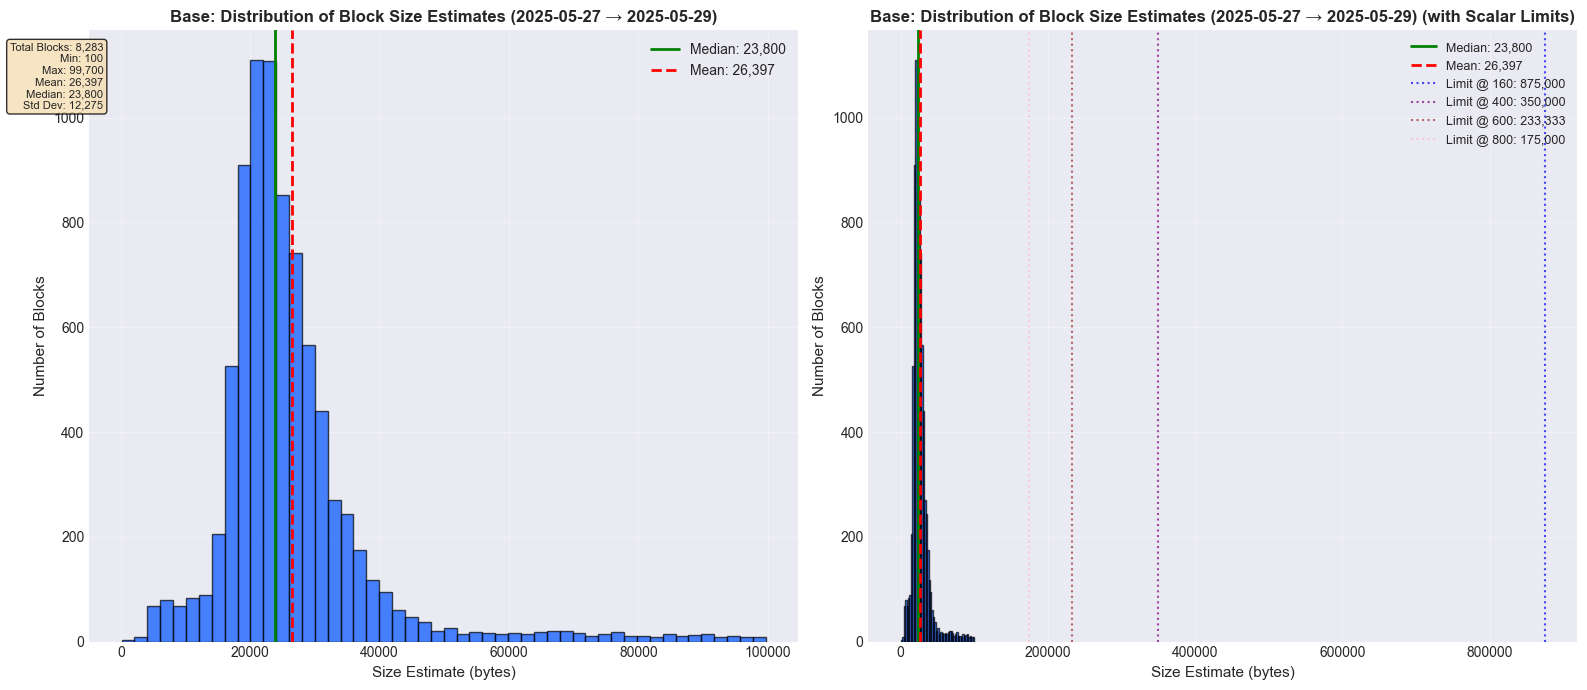

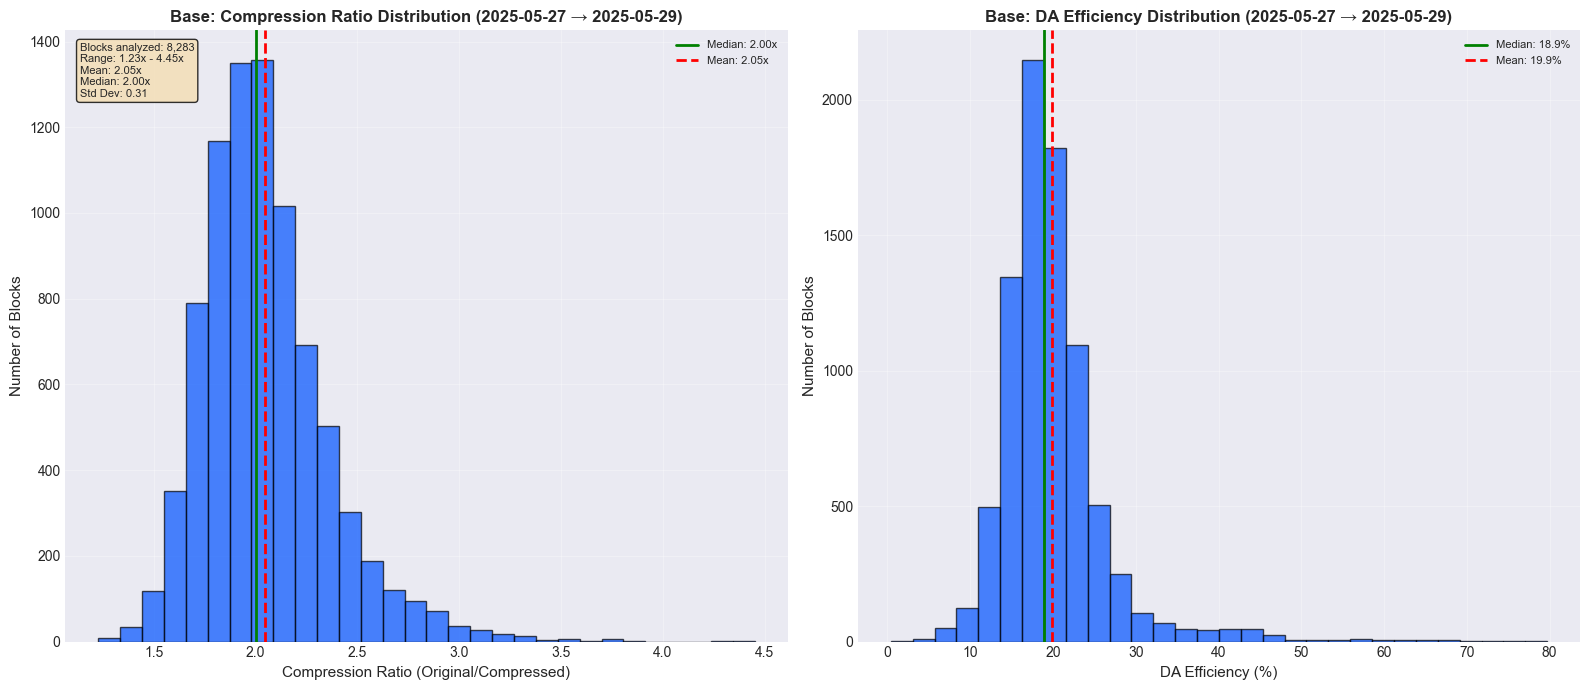

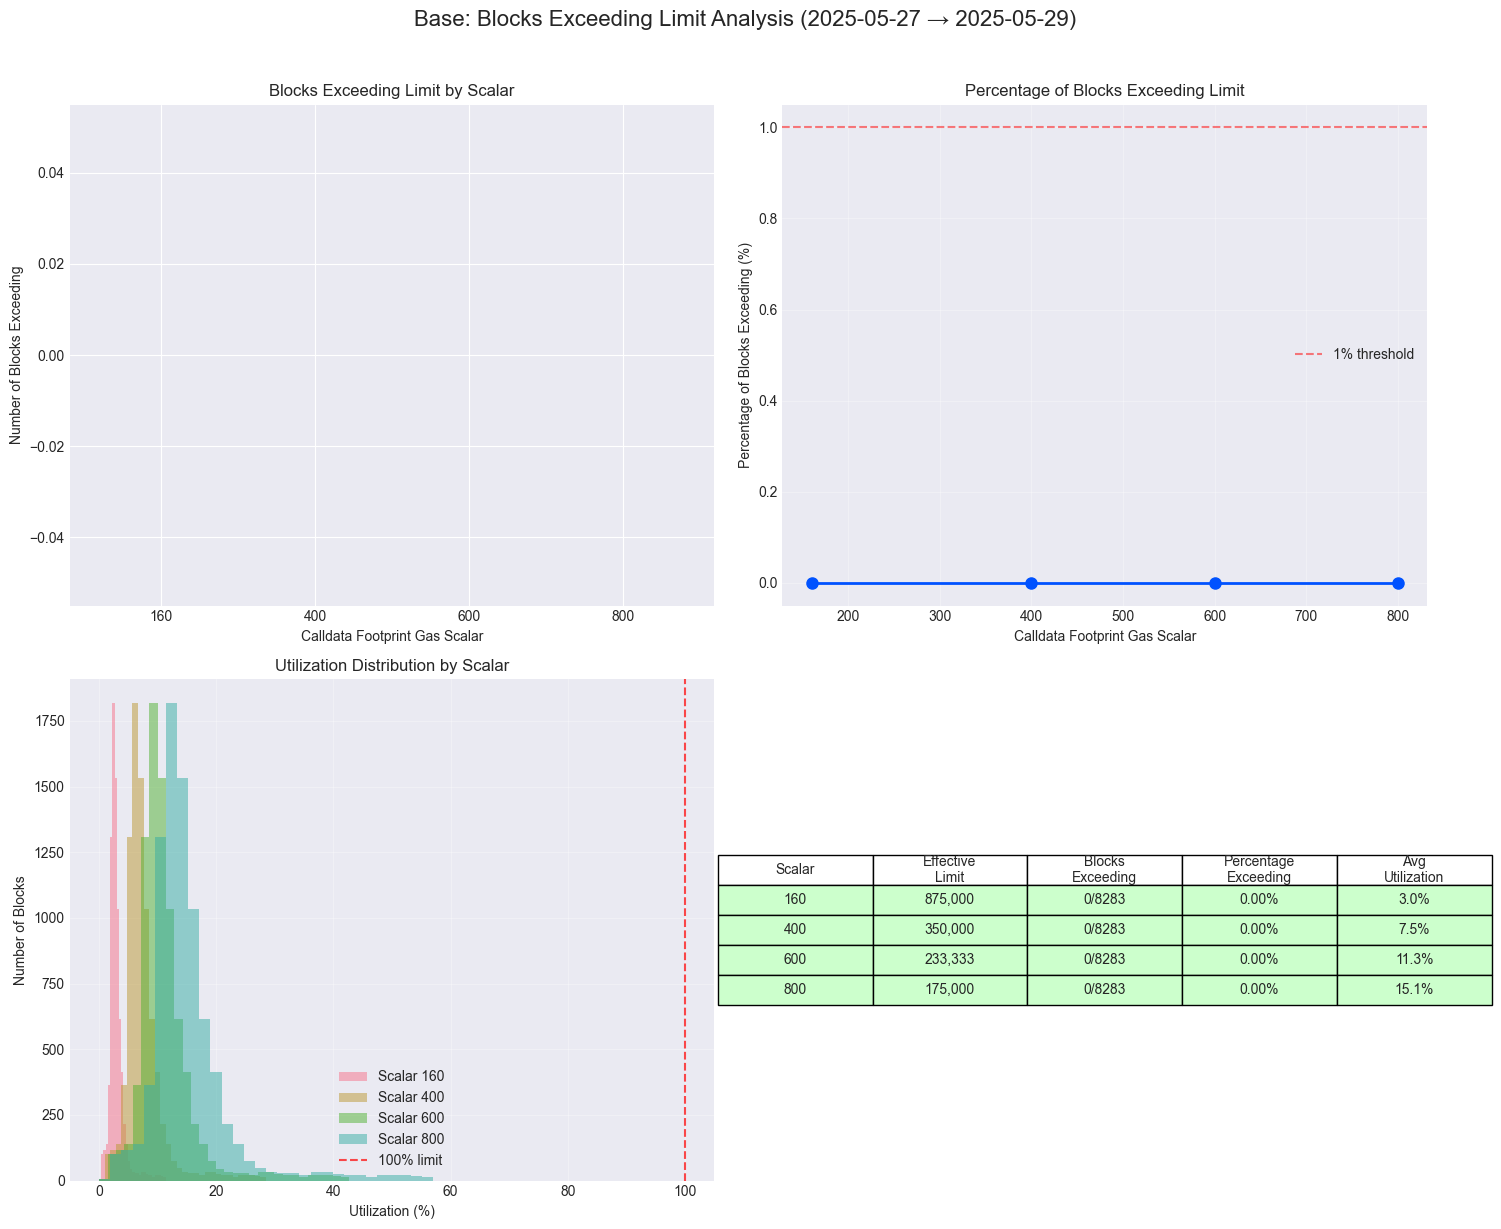

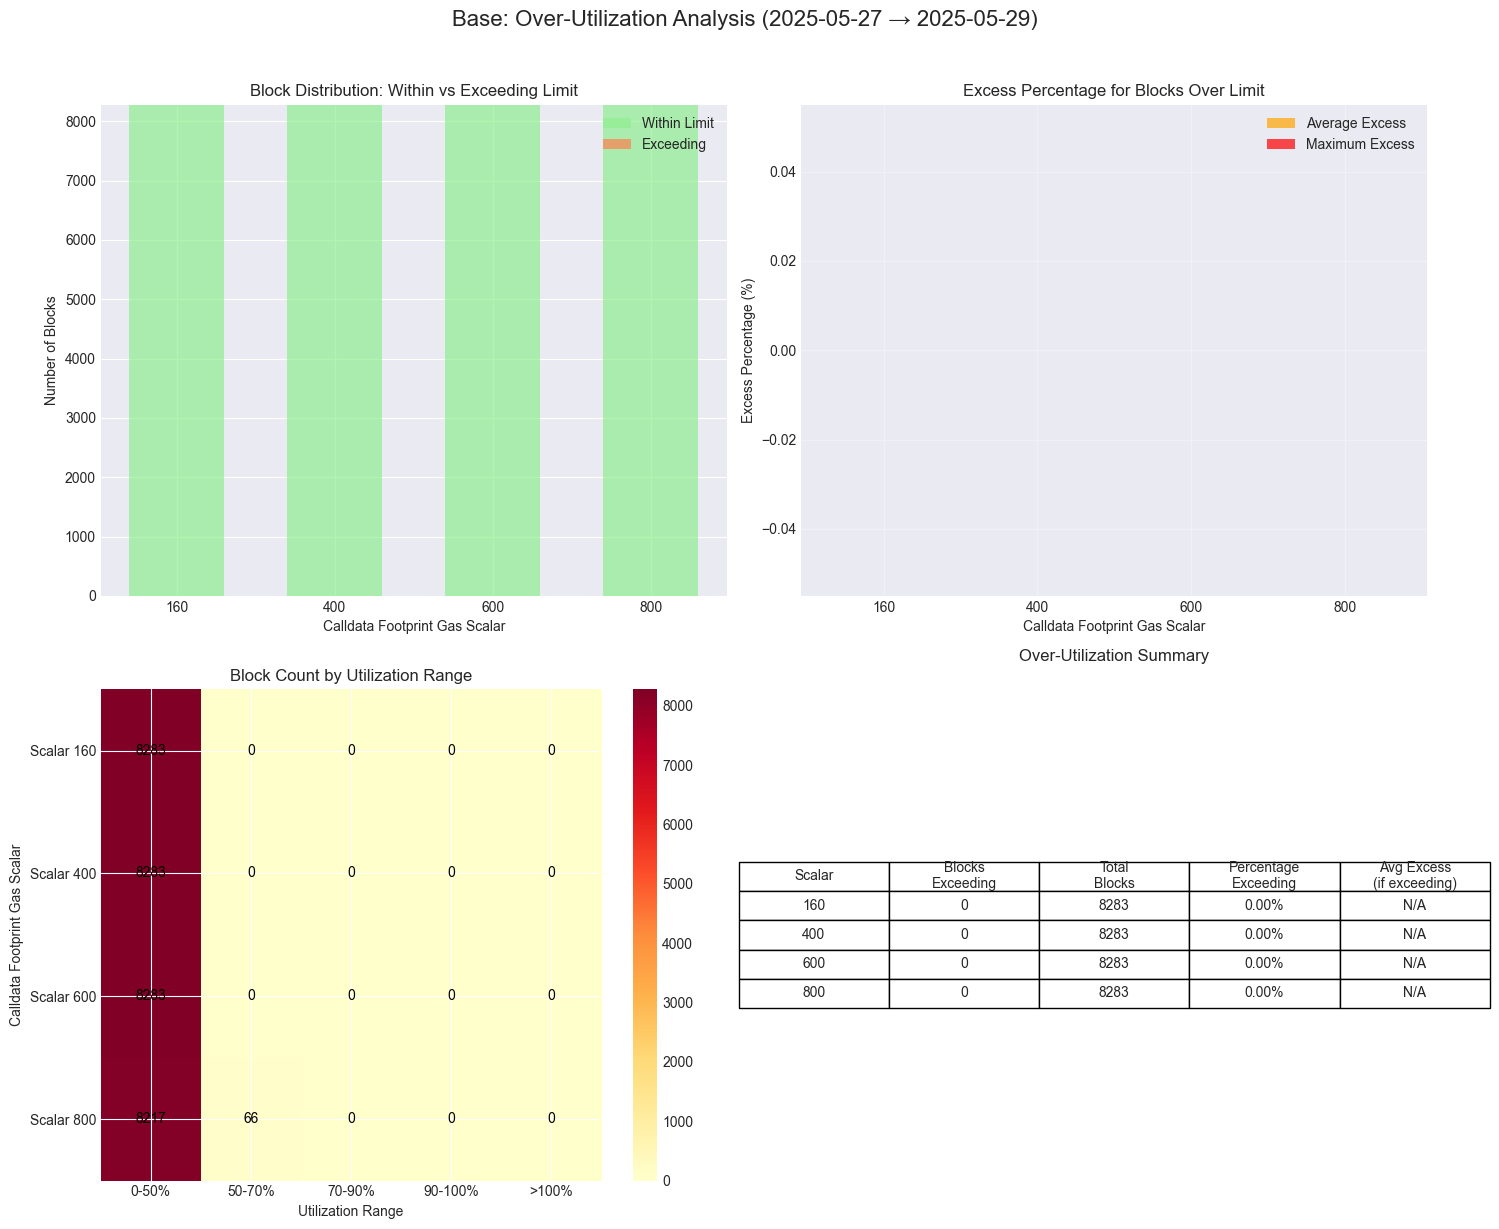

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


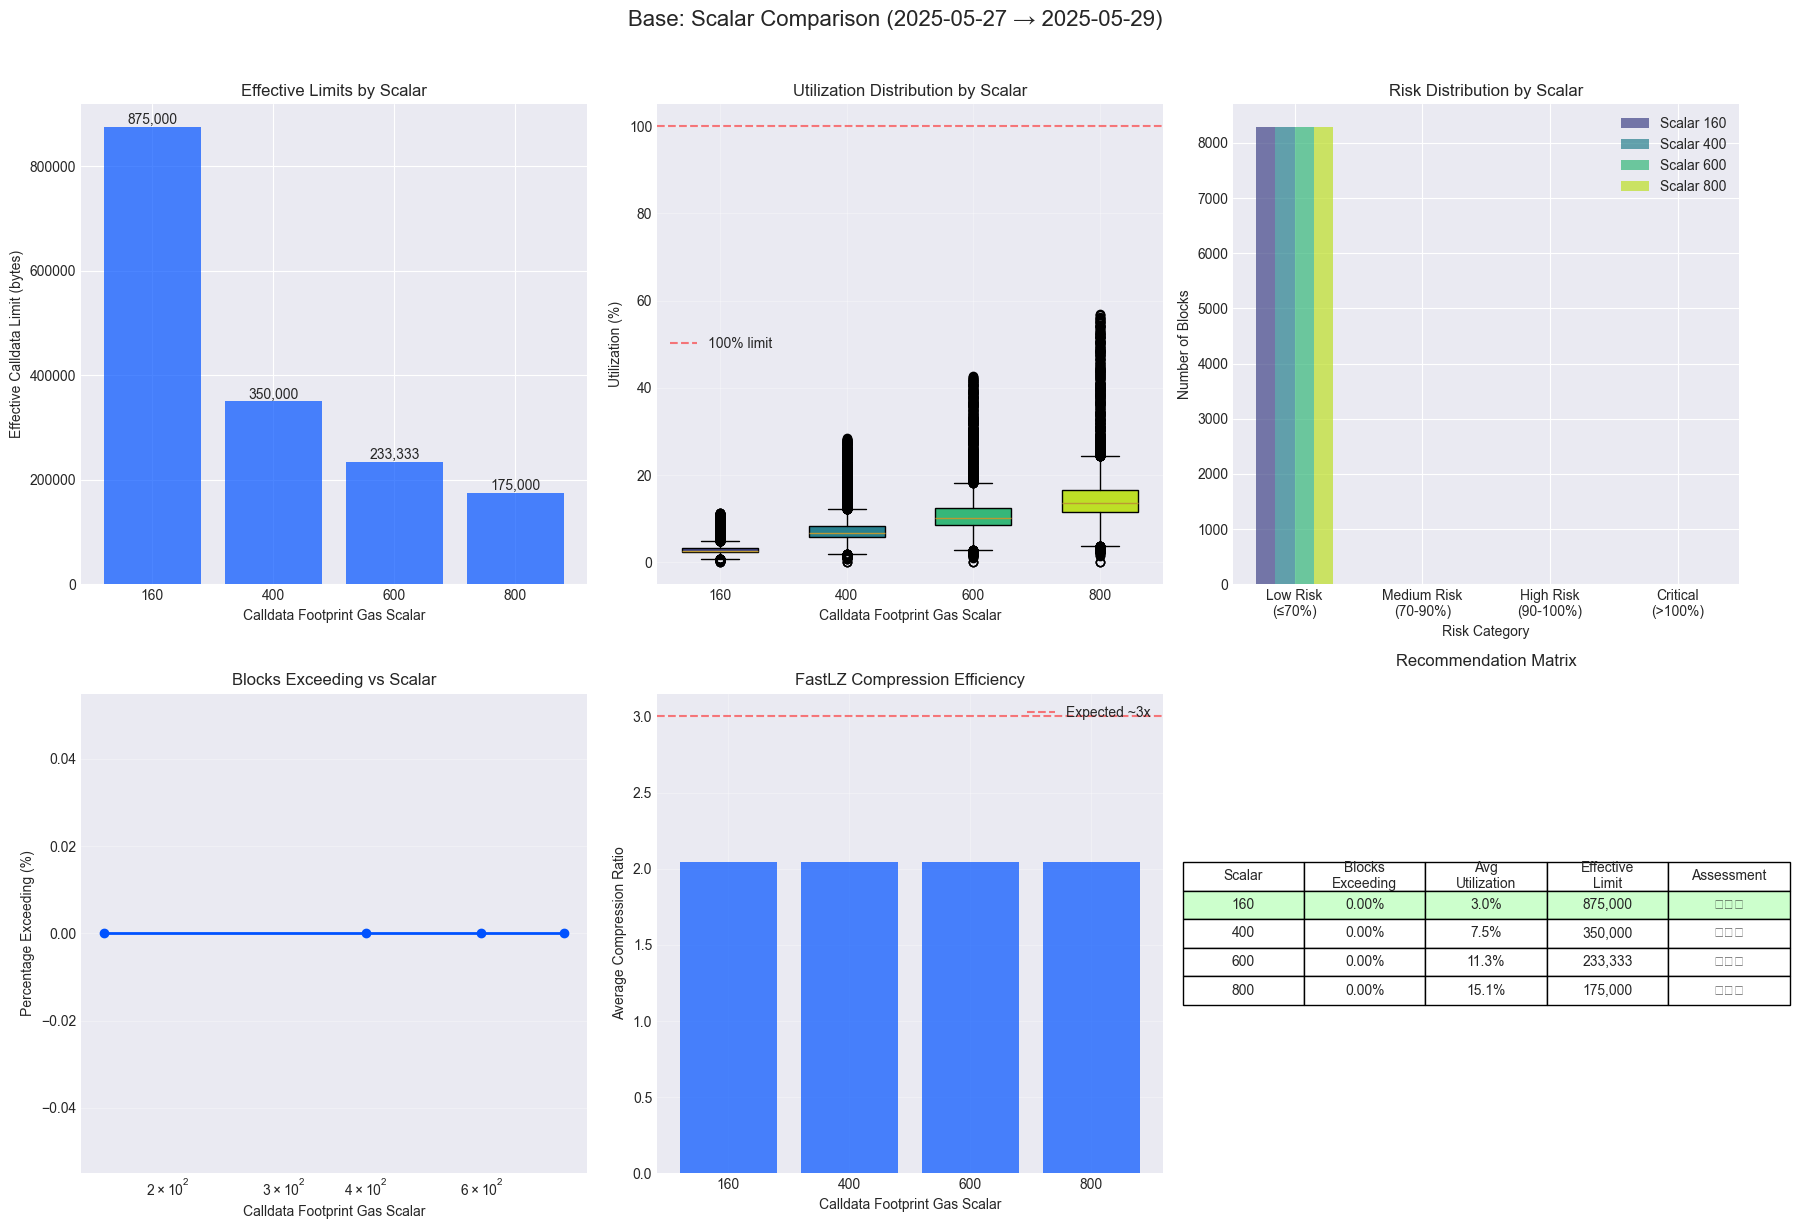

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


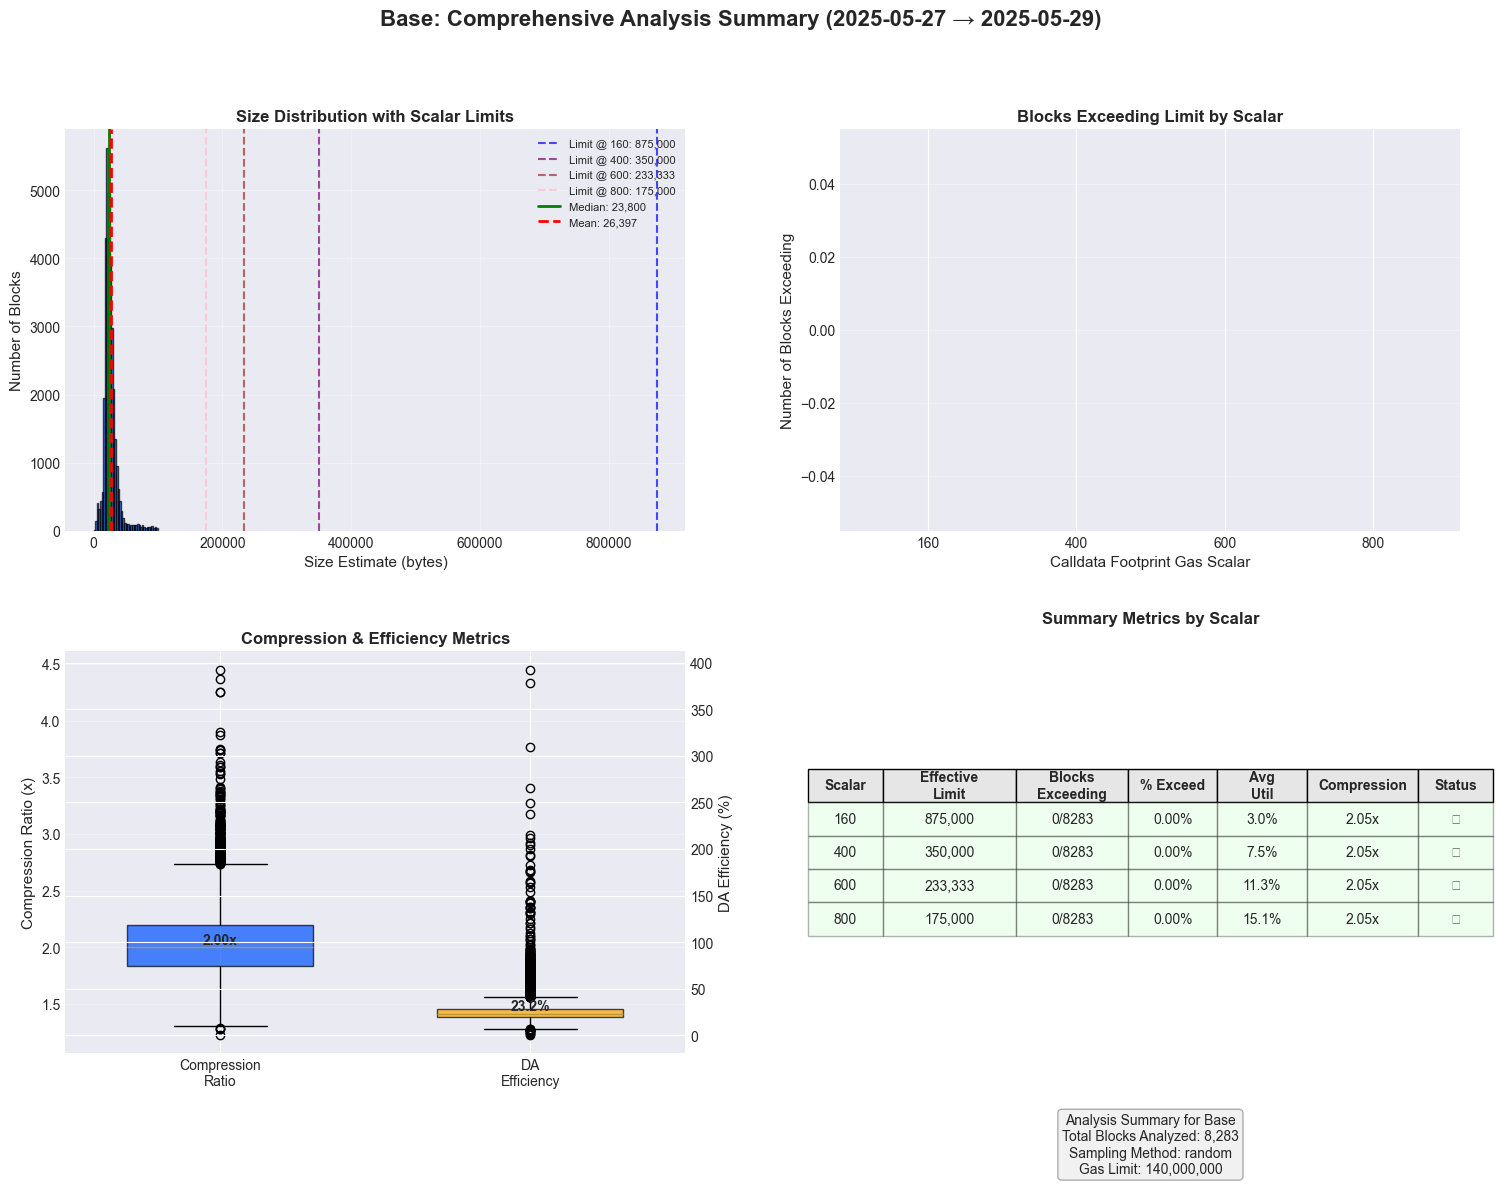

In [10]:
# Generate all Jovian visualizations with enhanced features
if analysis_results:
    print(f"📊 Generating enhanced visualizations for {get_chain_display_name(CHAIN)}...")
    
    # Generate all visualizations (includes new comprehensive summary)
    figures = generate_all_visualizations(
        results_by_scalar=analysis_results,
        output_dir=OUTPUT_DIR,
        chain=CHAIN,
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    print(f"\n✅ Generated {len(figures)} visualizations:")
    print("   1. Size estimates histogram (with vertical lines & zones)")
    print("   2. Compression ratio histogram (with percentiles & zones)")
    print("   3. Blocks exceeding limits analysis")
    print("   4. Excess distribution")
    print("   5. Over-utilization percentages")
    print("   6. Scalar comparison")
    print("   7. Comprehensive summary (NEW)")
    print(f"\n📁 Saved to: {OUTPUT_DIR}")

# Step 7: Analyze Time-Series Data

In [56]:
def blocks_to_frame(analysis_results, scalar_to_peek):
    res = analysis_results[scalar_to_peek]
    blocks = res.block_analyses
    rows = []
    for b in blocks:
        rows.append({
            "block_number": b.block_number,
            "block_time_utc": datetime.fromtimestamp(b.block_timestamp, tz=timezone.utc),
            "block_time_cdt": datetime.fromtimestamp(b.block_timestamp, tz=timezone.utc).astimezone(timezone(timedelta(hours=-5))),
            "base_fee_per_gas": getattr(b, "base_fee_per_gas", None),
            "tx_count": getattr(b, "tx_count", None),
            "total_da_footprint": getattr(b, "total_da_footprint", None),
            "total_da_usage_estimate": getattr(b, "total_da_usage_estimate", None),
            "block_gas_limit": getattr(b, "block_gas_limit", None),
            "block_gas_used": getattr(b, "block_gas_used", None),
            "calldata_utilization": getattr(b, "calldata_utilization", None),
            "utilization_vs_gas_used": getattr(b, "utilization_vs_gas_used", None),
            "total_calldata_size": getattr(b, "total_calldata_size", None),
            "total_fastlz_size": getattr(b, "total_fastlz_size", None),
        })
    df = pd.DataFrame(rows).sort_values("block_time_utc").reset_index(drop=True)
    df["footprint_vs_limit"] = df["total_da_footprint"] / df["block_gas_limit"]
    df["gas_used_ratio"] = df["block_gas_used"] / df["block_gas_limit"]
    return df

# def resample_to_rolling_windows(df, time_column, agg_map, rolling_window_mins=1):
#     df_converted = (
#         df.set_index(time_column)
#         .resample(f"{rolling_window_mins}min")
#         .agg(agg_map)
#     )

#     # flatten MultiIndex columns -> friendly names
#     df_converted.columns = [
#         f"{col}_{agg}" for col, agg in df_converted.columns
#     ]

#     # fill only the additive series; keep means as NaN if there was no data that minute
#     return df_converted.fillna({"tx_count_sum": 0, "total_da_usage_sum": 0, "base_fee_per_gas_mean": 0}).reset_index()

def resample_to_rolling_windows(df, time_column, agg_map, rolling_window_mins=1):
    df_converted = (
        df.set_index(time_column)
        .resample(f"{rolling_window_mins}min")
        .agg(agg_map)
    )

    # flatten MultiIndex columns -> friendly names
    df_converted.columns = [
        f"{col}_{agg}" for col, agg in df_converted.columns
    ]

    df_converted = df_converted.reset_index()

    # drop rows where additive metrics are all zero (or selectively drop where a specific column is 0)
    drop_cols = ["tx_count_sum", "total_da_usage_estimate_sum", "base_fee_per_gas_mean"]
    df_filtered = df_converted[
        ~(df_converted[drop_cols] == 0).all(axis=1)
    ]

    return df_filtered

def format_wei_ticks(y, _):
    if y >= 1e9:
        return f"{y/1e9:.2f} Gwei"
    elif y >= 1e6:
        return f"{y/1e6:.2f} Mwei"
    elif y >= 1e3:
        return f"{y/1e3:.2f} kwei"
    elif y >= 1:
        return f"{int(y)} wei"
    else:
        return ""

def da_throttling_time_series_charts(df, time_column, column_name, log_y=False):
    plt.figure(figsize=(10, 4))
    plt.plot(df[time_column], df[column_name], color="crimson", alpha=0.8)

    ax = plt.gca()

    if log_y:
        ax.set_yscale("log")

    if column_name == "base_fee_per_gas_mean":
        ax.yaxis.set_major_formatter(FuncFormatter(format_wei_ticks))

    # Keep whatever timezone the series has; fall back to UTC
    series_tz = getattr(df[time_column].dt, "tz", None) or ZoneInfo("UTC")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %H:%M", tz=series_tz))

    plt.gcf().autofmt_xdate()
    plt.title(f"{column_name} ({time_column})")
    plt.xlabel(time_column)
    plt.ylabel(column_name + (" [log scale]" if log_y else ""))
    plt.tight_layout()



In [51]:
df1.head()

,block_time_cdt,total_da_usage_estimate_sum,total_da_usage_estimate_mean,base_fee_per_gas_mean,tx_count_sum,tx_count_mean
0,2025-05-27 16:10:00-05:00,86000.0,28666.666667,602996.666667,860,286.666667
1,2025-05-27 16:15:00-05:00,637700.0,24526.923077,576650.269231,6377,245.269231
2,2025-05-27 16:20:00-05:00,419100.0,24652.941176,596287.294118,4191,246.529412
3,2025-05-27 16:25:00-05:00,340700.0,26207.692308,643636.384615,3407,262.076923
4,2025-05-27 16:30:00-05:00,282600.0,25690.909091,595123.090909,2826,256.909091


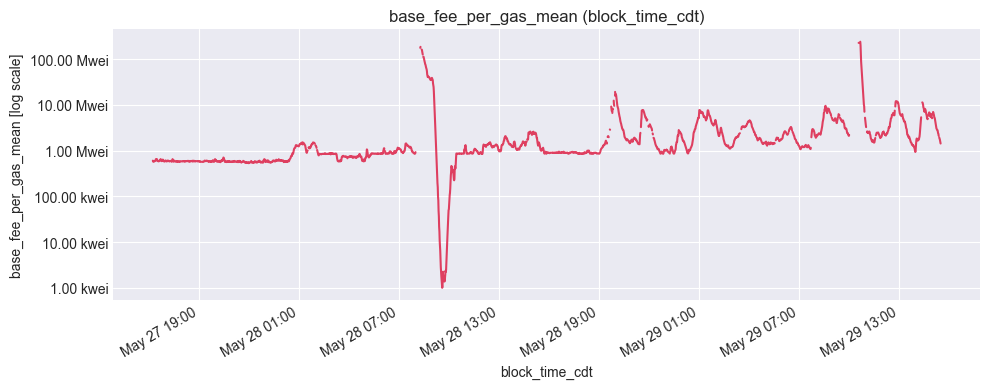

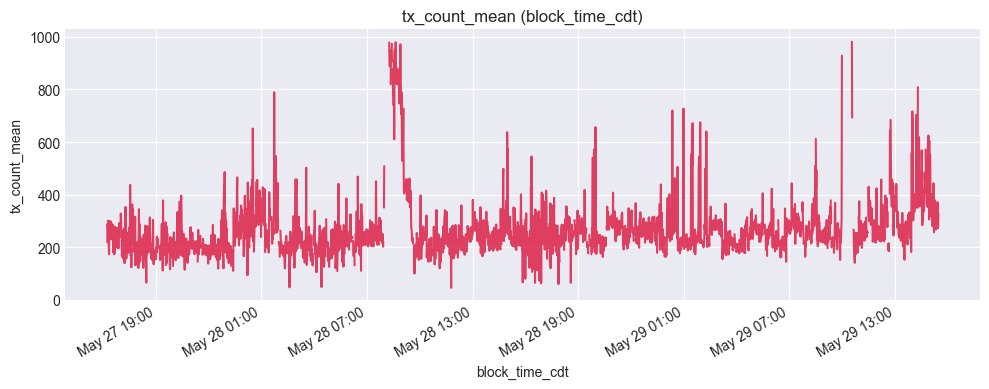

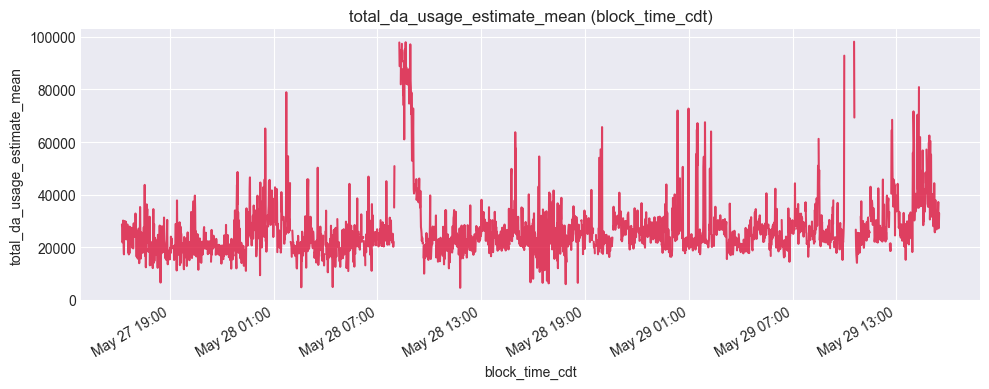

In [58]:
df = blocks_to_frame(analysis_results, 400)

agg_map = {
    "total_da_usage_estimate": ["sum", "mean"],
    "base_fee_per_gas": "mean",
    "tx_count": ["sum", "mean"],
}
df1 = resample_to_rolling_windows(df, "block_time_cdt", agg_map, 1)

da_throttling_time_series_charts(df1, "block_time_cdt", "base_fee_per_gas_mean", log_y=True)
da_throttling_time_series_charts(df1, "block_time_cdt", "tx_count_mean", log_y=False)
da_throttling_time_series_charts(df1, "block_time_cdt", "total_da_usage_estimate_mean", log_y=False)

In [13]:
# da_throttling_time_series_charts(df, "block_time_pt", "base_fee_per_gas")
# da_throttling_time_series_charts(df, "block_time_pt", "tx_count")
# da_throttling_time_series_charts(df, "block_time_pt", "total_da_usage_estimate")

In [59]:
!python -m nbconvert --to html da_throttling_analysis.ipynb --output saved_output_html/{CHAIN}_{SAMPLING_METHOD}_{START_DATE}_{END_DATE}.html

/Users/chuxinhuang/work/op-analytics/.venv/bin/python: No module named nbconvert
